In [1]:
from utils.utils import calculate_attributions
import matplotlib.pyplot as plt 
import numpy as np

In [11]:
import pandas as pd
import numpy as np
dataset = "GunPoint"
task  = 'task_1'
"""
output_directory = f'G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/{dataset}/fcn/fcn_itr_/original/'
att_train = np.load(output_directory + f"calculated_attribution_train_{task}.npy",allow_pickle=True)
att_test = np.load(output_directory + f"calculated_attribution_test_{task}.npy",allow_pickle=True)"""

'\noutput_directory = f\'G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/{dataset}/fcn/fcn_itr_/original/\'\natt_train = np.load(output_directory + f"calculated_attribution_train_{task}.npy",allow_pickle=True)\natt_test = np.load(output_directory + f"calculated_attribution_test_{task}.npy",allow_pickle=True)'

In [70]:
root_dir = 'G:/My Drive/master thesis/code/dl-4-tsc-mtl'
archive_name = 'ucr'
classifier = 'fcn_itr_'
dataset_name =  'GunPoint'
data_source = 'original'
mode = 'stl'

from utils.utils import read_dataset

def calculate_att_per_timestep(root_dir, archive_name, classifier, dataset_name, data_source, mode, task=1):
    #import tensorflow_addons as tfa
    import tensorflow.keras as keras
    import sklearn
    import os

    max_length = 2000
    
    if task == 1: 
        datasets_dict = read_dataset(root_dir, archive_name, dataset_name,  'original')
    elif task == 2: 
        datasets_dict = read_dataset(root_dir, archive_name, dataset_name,   data_source)
        
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

    # transform to binary labels
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()
    
    orgx_train = x_train
    orgx_test = x_test
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

    model = keras.models.load_model( f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5',compile=False)

    if mode == 'stl': 
        relu, softm = (-3,-1)
        
    w_k_c = model.layers[softm].get_weights()[0]  # weights for each filter k for each class c

    # the same input
    new_input_layer = model.inputs
    new_output_layer = [model.layers[relu].output, model.layers[softm].output]
    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)
    output = []

    for orgx_vals,x_vals,y_vals in [[orgx_train,x_train,y_train],[orgx_test,x_test,y_test]]:
        attr = list()
        for idx,ts in enumerate(x_vals):
            ts = ts.reshape(1, -1, 1)
            [conv_out, predicted] = new_feed_forward([ts])
            cas = np.zeros(dtype=np.float64, shape=(conv_out.shape[1]))

            for k, w in enumerate(w_k_c[:,int(y_vals[idx]-1)]):
                cas += w * conv_out[0, :, k] 
            attr.append([y_vals,orgx_vals[idx],cas])
        output.append(attr)
    return output
att_train,att_test = calculate_att(root_dir, archive_name, classifier,  dataset_name, data_source, mode, task=1)

"/content/drive/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_itr_/original/best_model.hdf5"

G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_itr_/original/best_model.hdf5
(50, 150, 1) (150, 150, 1)


'/content/drive/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_itr_/original/best_model.hdf5'

In [73]:
att = calculate_att(root_dir, archive_name, classifier,  dataset_name, data_source, mode, task=1)

G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_itr_/original/best_model.hdf5
(50, 150, 1) (150, 150, 1)


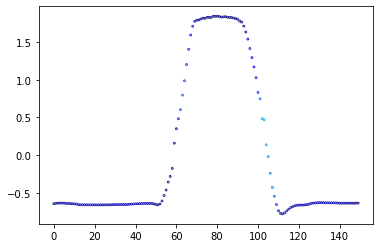

In [72]:
%matplotlib inline

plt.scatter(np.arange(len(att_train[0][1])),att_train[0][1],c=att_train[0][2],cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=2.0)

In [75]:
def create_pointwise_explanation(attributions):
    output = []
    for split in attributions:
        explanations = []
        for ts in split: 
            y_values = ts[0]
            attributions = ts[2]
            explanations.append(np.concatenate((y_values,attributions), axis=None))    
        output.append(np.array(explanations))
    return output

create_explanations(att)

[array([[ 2.        ,  2.        ,  1.        , ..., -0.26595339,
         -0.76490394, -0.19633039],
        [ 2.        ,  2.        ,  1.        , ..., -0.27871747,
         -0.76107595, -0.19983189],
        [ 2.        ,  2.        ,  1.        , ...,  0.43241382,
          1.04015972,  0.02578511],
        ...,
        [ 2.        ,  2.        ,  1.        , ..., -0.7435846 ,
         -0.93719258, -0.95432915],
        [ 2.        ,  2.        ,  1.        , ...,  0.51422926,
          1.04485   ,  0.01454503],
        [ 2.        ,  2.        ,  1.        , ..., -0.79064568,
         -2.06388897, -0.34125896]]),
 array([[ 1.        ,  2.        ,  2.        , ..., -1.30257881,
          1.73566708,  0.54202425],
        [ 1.        ,  2.        ,  2.        , ..., -0.32569549,
         -0.77477224, -0.21530297],
        [ 1.        ,  2.        ,  2.        , ..., 24.69570383,
          5.8048848 , -0.08741638],
        ...,
        [ 1.        ,  2.        ,  2.        , ..., -

In [ ]:
def save_explanations(data, root_dir, archive_name, appendix, dataset_name):
    train_explanation,test_explanation = data
    print(train_explanation.shape, test_explanation.shape)
    dir_path = root_dir + '/archives/' + archive_name + '/' + dataset_name + '/' + appendix + '/' 
    create_directory(dir_path)
    np.savetxt(dir_path + dataset_name + "_TRAIN", train_explanation, delimiter=',')
    np.savetxt(dir_path + dataset_name + "_TEST", test_explanation, delimiter=',')
    print("Successfully created explanation done.")